# **MODÈLE PRÉDICTIF POUR ACCORD DE PRÊT : Premières analyses et premier modèle.**

## **Nouveau Check-up des données**

#### Analyses :

- **Types de variables** :

    - Qualitatives : 3 string

    - Quantitatives : 7 integer
    
    - Dont : la TARGET et 2 variables binaires

- **Lignes et colonnes** : Il nous reste 745463 lignes × 10 colonnes (ville, pays, nb_employes, creation, emploi_crees, emplois_retenus, emplacement, petit_pret, secteur, TARGET).

- **Visualisation de la target** : Les données de notre variable cible ne sont pas équitablement réparties, nous avons 15% des entreprises qui ont été radiées contre 85% de paiements terminés.

- **Relation Variables / Target** : 
    - À première vue il semble y avoir un lien avec le nombre d'emplois créés et retenus.
    - Il semble également y avoir un lien avec le lieu d'implentation de l'entreprise.
    - De même pour le secteur d'activité et le type d'entreprise.

## **Imports et Dataframes**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier, SGDRegressor

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report

from joblib import dump
from joblib import load

import sweetviz as sv

In [3]:
df = pd.read_csv('données/données_clean.csv')

df

,pays,mois,nb_employes,creation,emploi_crees,franchise,emplacement,cred_renouvelable,petit_pret,montant,secteur,TARGET
0,IN,84,4,1,0,1,0,N,Y,"$60,000.00",44,0
1,IN,60,2,1,0,1,0,N,Y,"$40,000.00",72,0
2,IN,180,7,0,0,1,0,N,N,"$287,000.00",62,0
3,OK,60,2,0,0,1,0,N,Y,"$35,000.00",0,0
4,FL,240,14,0,7,1,0,N,N,"$229,000.00",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
745445,OH,60,6,0,0,1,0,N,N,"$70,000.00",44,0
745446,OH,60,6,0,0,1,0,Y,N,"$85,000.00",44,0
745447,CA,108,26,0,0,1,0,N,N,"$300,000.00",31,0
745448,HI,60,6,0,0,1,0,N,Y,"$75,000.00",0,1


## **2nd Nettoyage**

In [4]:
del df['pays']

In [5]:
df

,mois,nb_employes,creation,emploi_crees,franchise,emplacement,cred_renouvelable,petit_pret,montant,secteur,TARGET
0,84,4,1,0,1,0,N,Y,"$60,000.00",44,0
1,60,2,1,0,1,0,N,Y,"$40,000.00",72,0
2,180,7,0,0,1,0,N,N,"$287,000.00",62,0
3,60,2,0,0,1,0,N,Y,"$35,000.00",0,0
4,240,14,0,7,1,0,N,N,"$229,000.00",0,0
...,...,...,...,...,...,...,...,...,...,...,...
745445,60,6,0,0,1,0,N,N,"$70,000.00",44,0
745446,60,6,0,0,1,0,Y,N,"$85,000.00",44,0
745447,108,26,0,0,1,0,N,N,"$300,000.00",31,0
745448,60,6,0,0,1,0,N,Y,"$75,000.00",0,1


## **Colonne secure**

In [6]:
df['secure'] = df['mois'].apply(lambda x : 1 if x >= 240 else 0)

## **Colonne type_entreprise**

In [7]:
def type_entreprise (nb_employes=int):
    if nb_employes == 0:
        return 'AUTO'
    elif nb_employes < 10:
        return 'TPE'
    elif nb_employes < 250:
        return 'PME'
    elif nb_employes < 5000:
        return 'ETI'
    else:
        return 'GE'

In [8]:
df['type_entreprise'] = df['nb_employes'].apply(lambda x : type_entreprise(x))

df

,mois,nb_employes,creation,emploi_crees,franchise,emplacement,cred_renouvelable,petit_pret,montant,secteur,TARGET,secure,type_entreprise
0,84,4,1,0,1,0,N,Y,"$60,000.00",44,0,0,TPE
1,60,2,1,0,1,0,N,Y,"$40,000.00",72,0,0,TPE
2,180,7,0,0,1,0,N,N,"$287,000.00",62,0,0,TPE
3,60,2,0,0,1,0,N,Y,"$35,000.00",0,0,0,TPE
4,240,14,0,7,1,0,N,N,"$229,000.00",0,0,1,PME
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745445,60,6,0,0,1,0,N,N,"$70,000.00",44,0,0,TPE
745446,60,6,0,0,1,0,Y,N,"$85,000.00",44,0,0,TPE
745447,108,26,0,0,1,0,N,N,"$300,000.00",31,0,0,PME
745448,60,6,0,0,1,0,N,Y,"$75,000.00",0,1,0,TPE


## **Premières analyses**

In [15]:
df_test = df.copy()

In [16]:
transformer = LabelBinarizer()
df_test['petit_pret'] = transformer.fit_transform(df_test['petit_pret'])
df_test['secure'] = transformer.fit_transform(df_test['secure'])
df_test['cred_renouvelable'] = transformer.fit_transform(df_test['cred_renouvelable'])

transformer = LabelEncoder()
df_test['type_entreprise'] = transformer.fit_transform(df_test['type_entreprise'])
df_test['secteur'] = transformer.fit_transform(df_test['secteur'])
# df_test['pays'] = transformer.fit_transform(df_test['pays'])

df_test

,mois,nb_employes,creation,emploi_crees,franchise,emplacement,cred_renouvelable,petit_pret,montant,secteur,TARGET,secure,type_entreprise
0,84,4,1,0,1,0,0,1,"$60,000.00",7,0,0,4
1,60,2,1,0,1,0,0,1,"$40,000.00",18,0,0,4
2,180,7,0,0,1,0,0,0,"$287,000.00",16,0,0,4
3,60,2,0,0,1,0,0,1,"$35,000.00",0,0,0,4
4,240,14,0,7,1,0,0,0,"$229,000.00",0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745445,60,6,0,0,1,0,0,0,"$70,000.00",7,0,0,4
745446,60,6,0,0,1,0,1,0,"$85,000.00",7,0,0,4
745447,108,26,0,0,1,0,0,0,"$300,000.00",5,0,0,3
745448,60,6,0,0,1,0,0,1,"$75,000.00",0,1,0,4


In [17]:
# bon_payeur = (df_test[df_test['TARGET'] == 0])
# mauvais_payeur = (df_test[df_test['TARGET'] == 1])

# bon_payeur.drop(['TARGET'], axis=1, inplace=True)
# mauvais_payeur.drop(['TARGET'], axis=1, inplace=True)

# bon_payeur_sample = bon_payeur.sample(10000)
# mauvais_payeur_sample = mauvais_payeur.sample(10000)

In [18]:
# for col in df_test.drop(['TARGET'], axis=1).columns:
#     plt.figure()
#     sns.distplot(bon_payeur_sample[col], label='bon payeur')
#     sns.distplot(mauvais_payeur_sample[col], label='mauvais payeur')
#     plt.legend()
#     plt.savefig(f"graphiques/second/hist_{col}.png")
#     plt.show()

In [19]:
# plt.figure()
# sns.clustermap(df_test.corr())
# plt.savefig("graphiques/second/cluster_correlation.png")
# plt.show()

In [20]:
# correlation = df_test.corr()
# correlation = pd.DataFrame(correlation['TARGET'])
# correlation.sort_values('TARGET', ascending=False, inplace=True)
# correlation.drop('TARGET', axis=0, inplace=True)

# correlation

In [21]:
# plt.figure(figsize=(20,10))

# sns.barplot(correlation, y='TARGET', x=correlation.index)
# plt.title('Corrélation de la prime d\'assurance en fonction des variables\n')
# plt.xlabel('\nType de variable')
# plt.ylabel('Corrélations\n')

# plt.savefig("graphiques/second/bar_correlation.png")
# plt.xticks(rotation=90)

# plt.show()

In [22]:
# plt.figure()
# sns.pairplot(df_test, hue='TARGET')
# plt.savefig("graphiques/pairplot_target.png")
# plt.show()

## **Relation TARGET / type_entreprise**

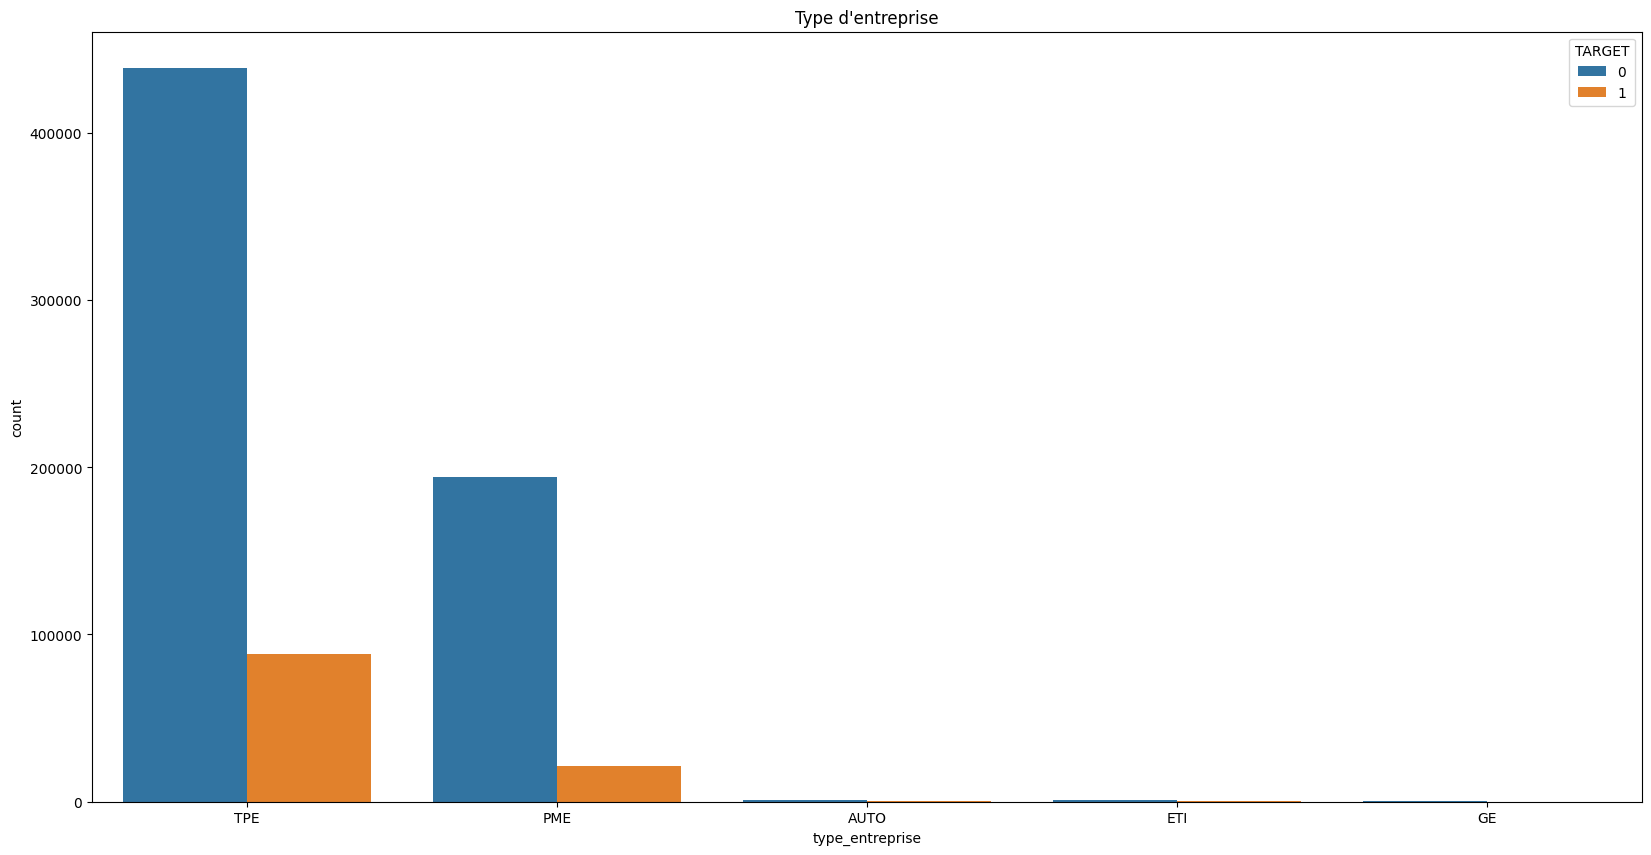

In [23]:
plt.figure(figsize=(20,10))

sns.countplot(data=df, x='type_entreprise', hue='TARGET')
plt.title("Type d'entreprise")

plt.show()

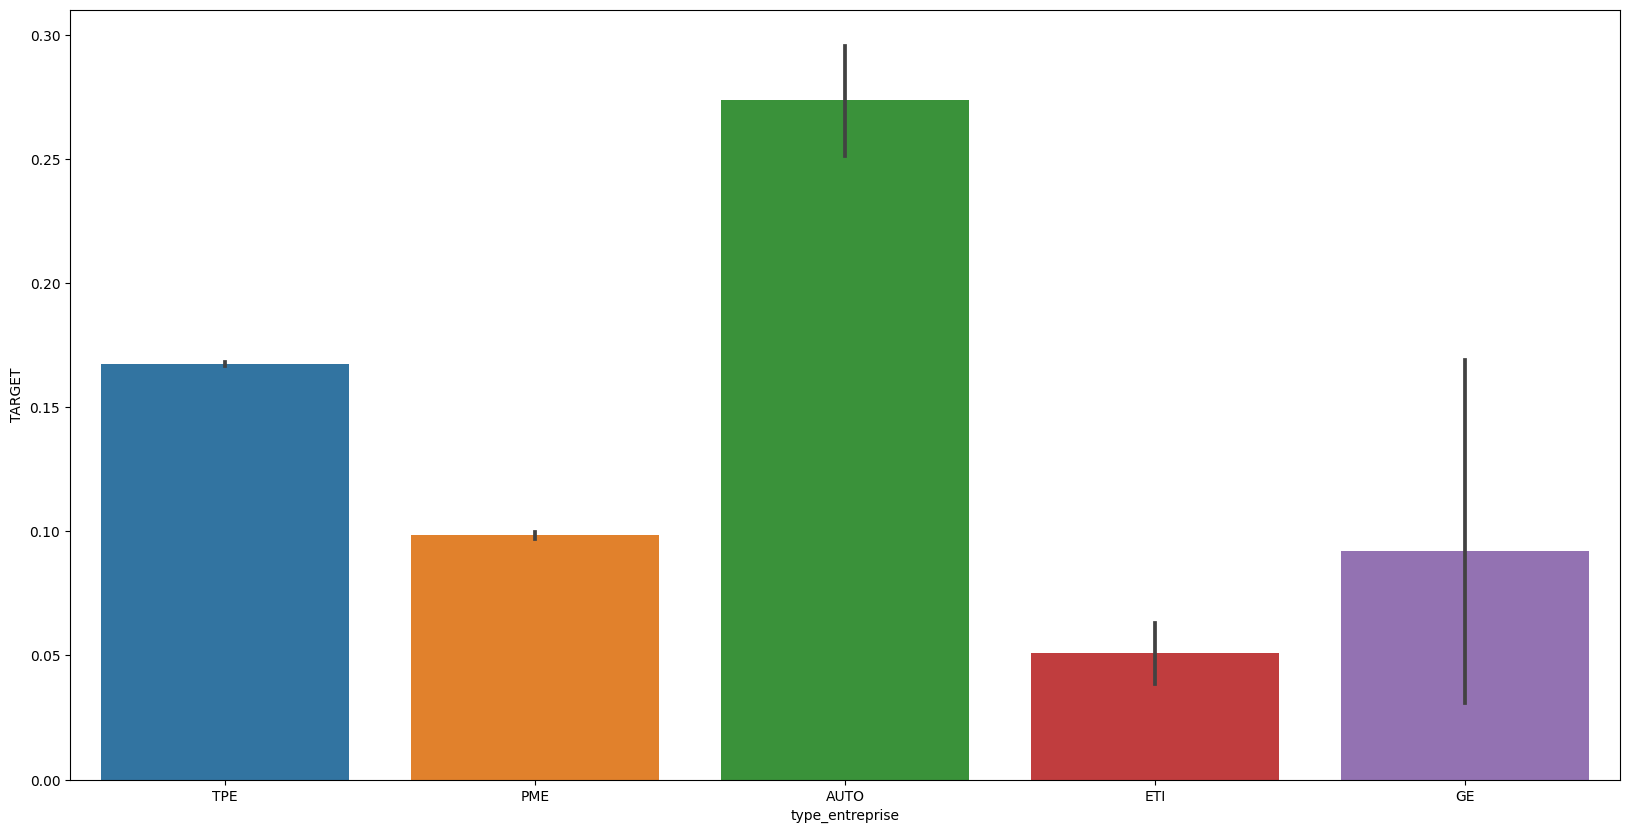

In [24]:
plt.figure(figsize=(20,10))

sns.barplot(data=df, x='type_entreprise', y='TARGET')

plt.show()

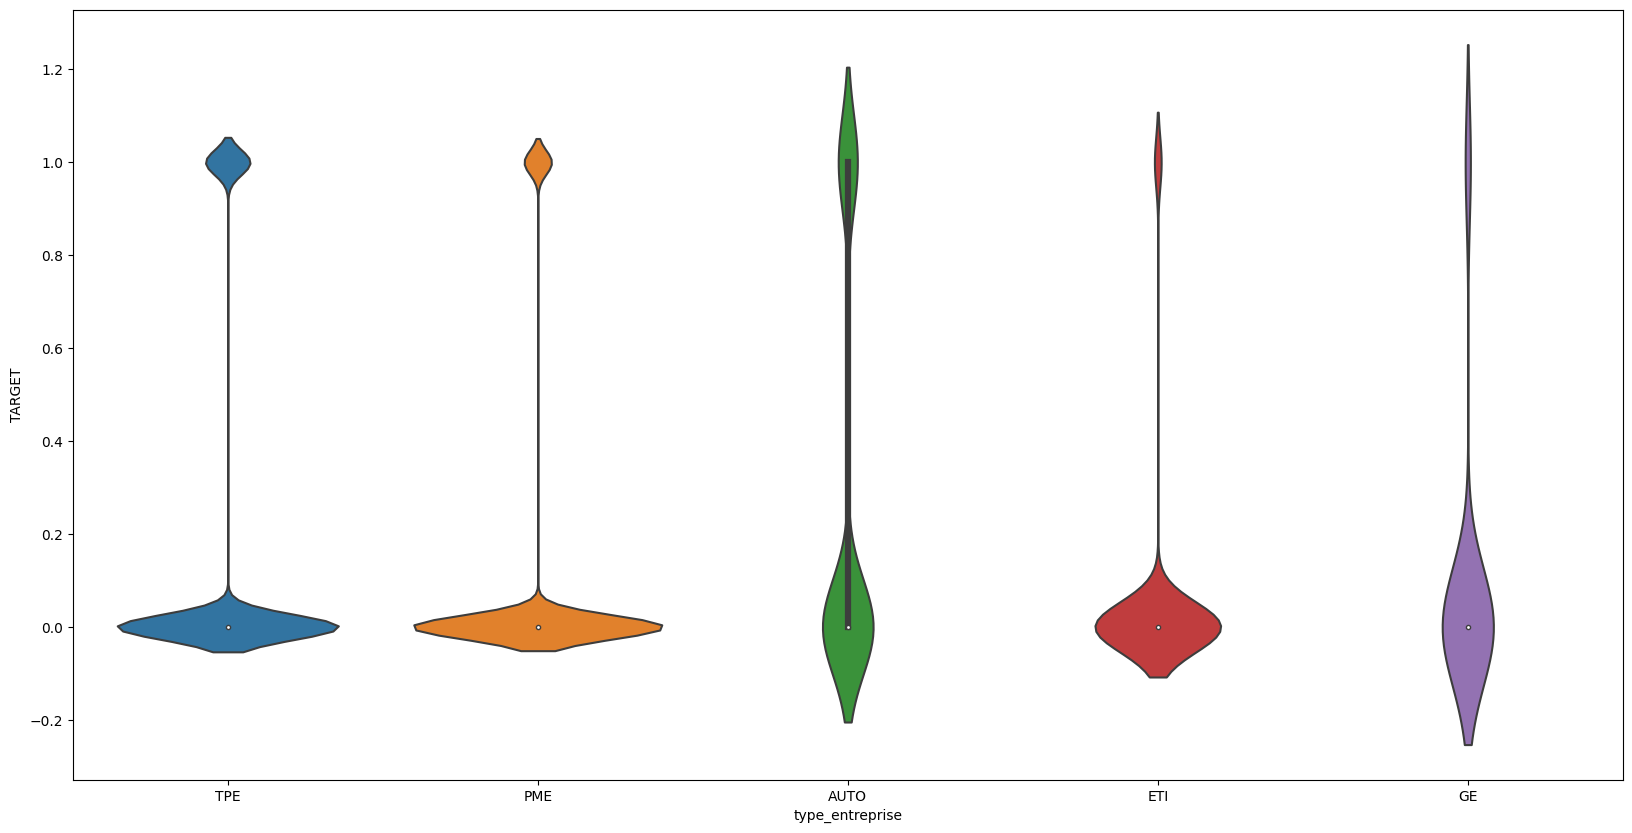

In [25]:
plt.figure(figsize=(20,10))

sns.violinplot(data=df, x='type_entreprise', y='TARGET')

plt.show()

## **Relation TARGET / secteur**

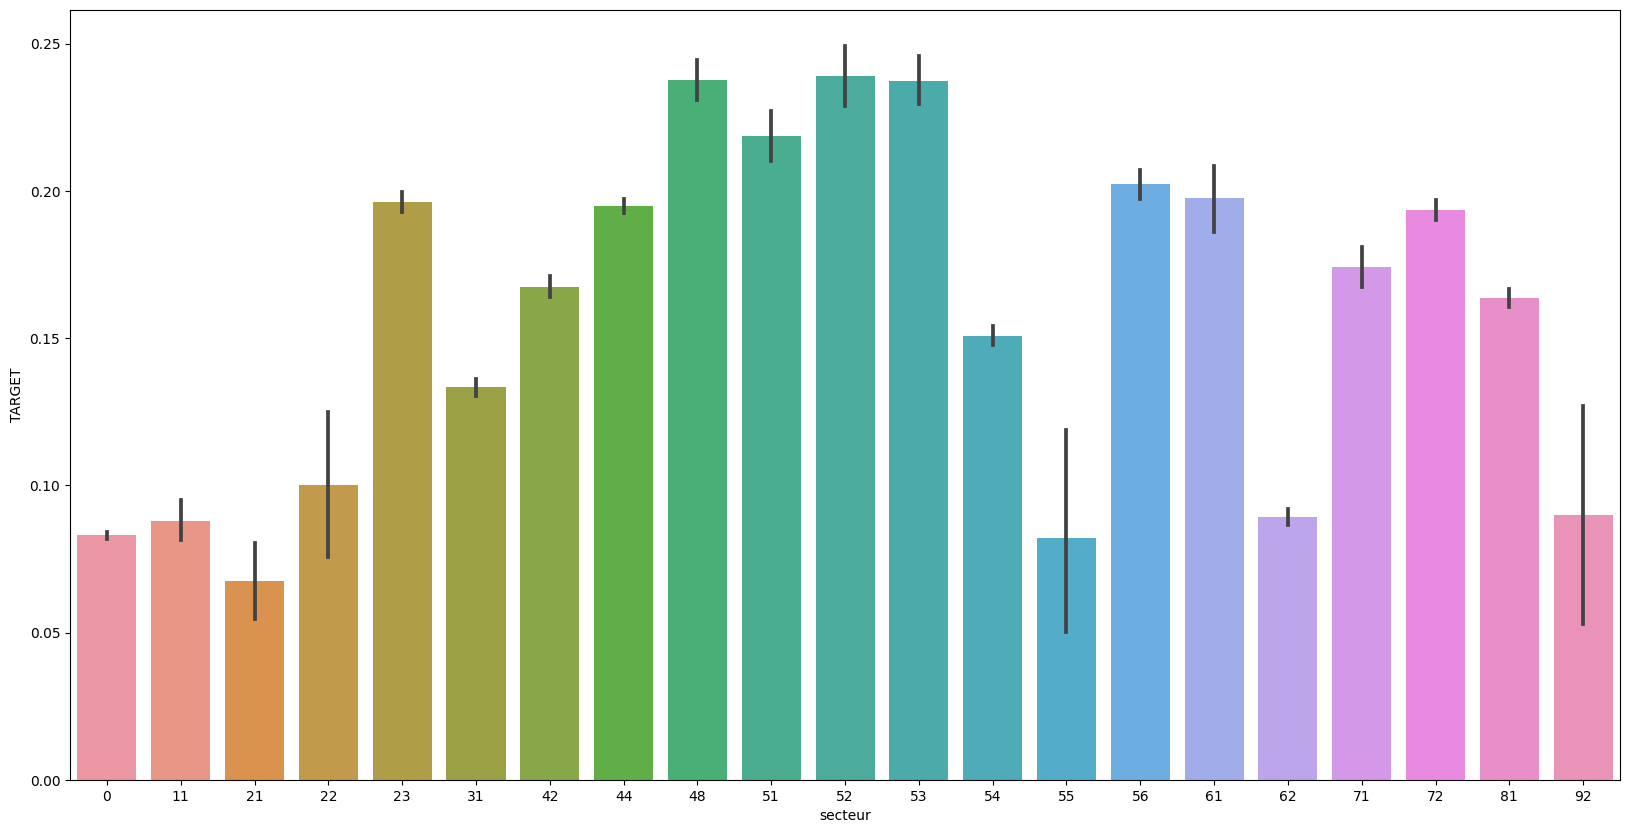

In [26]:
plt.figure(figsize=(20,10))

sns.barplot(data=df, x='secteur', y='TARGET')

plt.show()

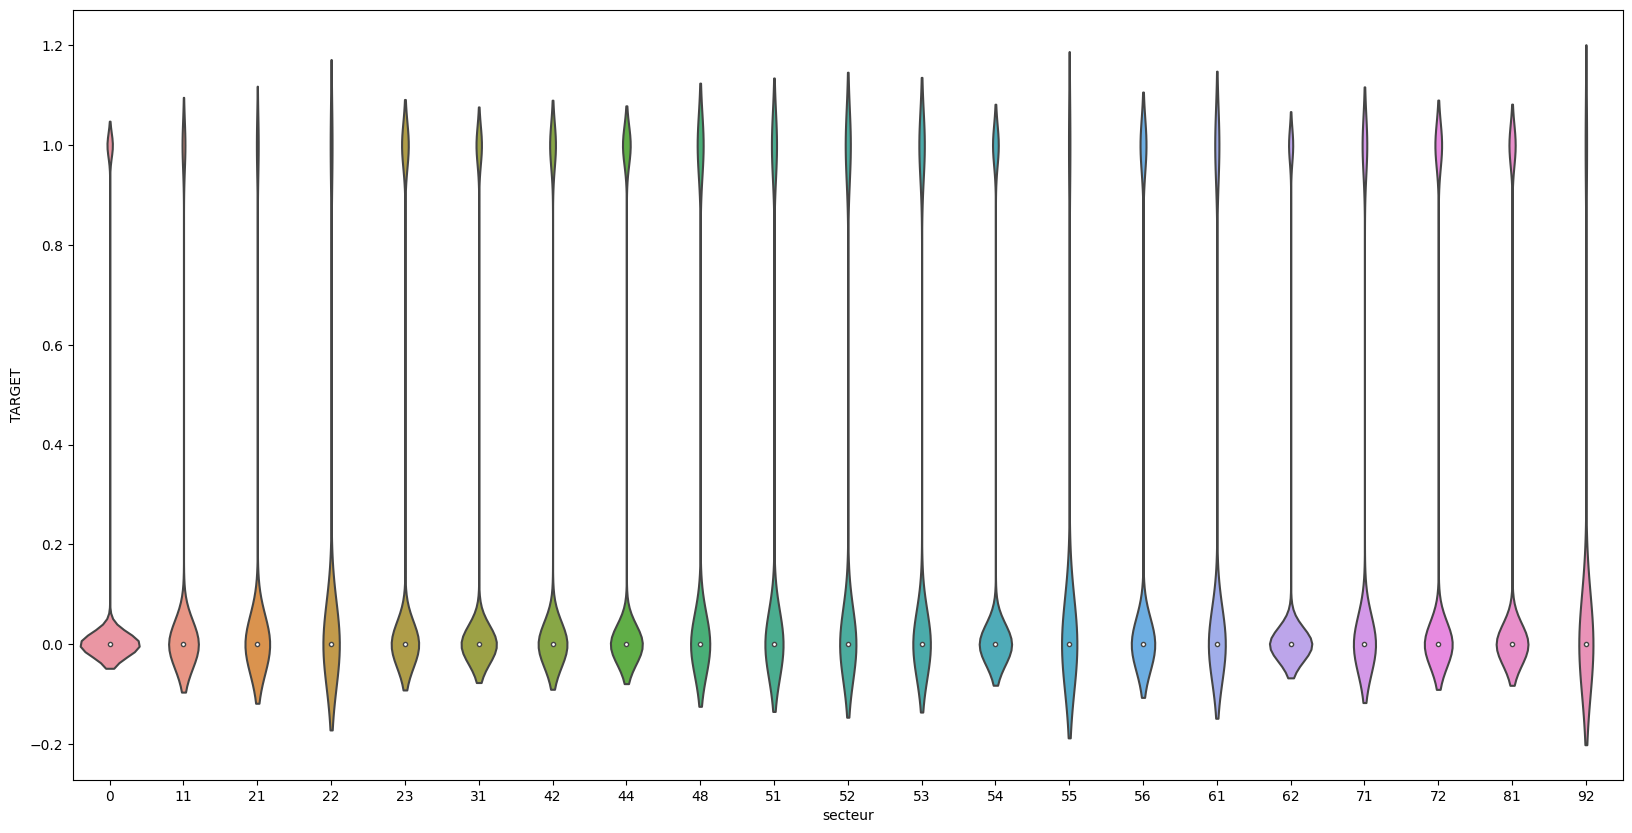

In [27]:
plt.figure(figsize=(20,10))

sns.violinplot(data=df, x='secteur', y='TARGET')

plt.show()

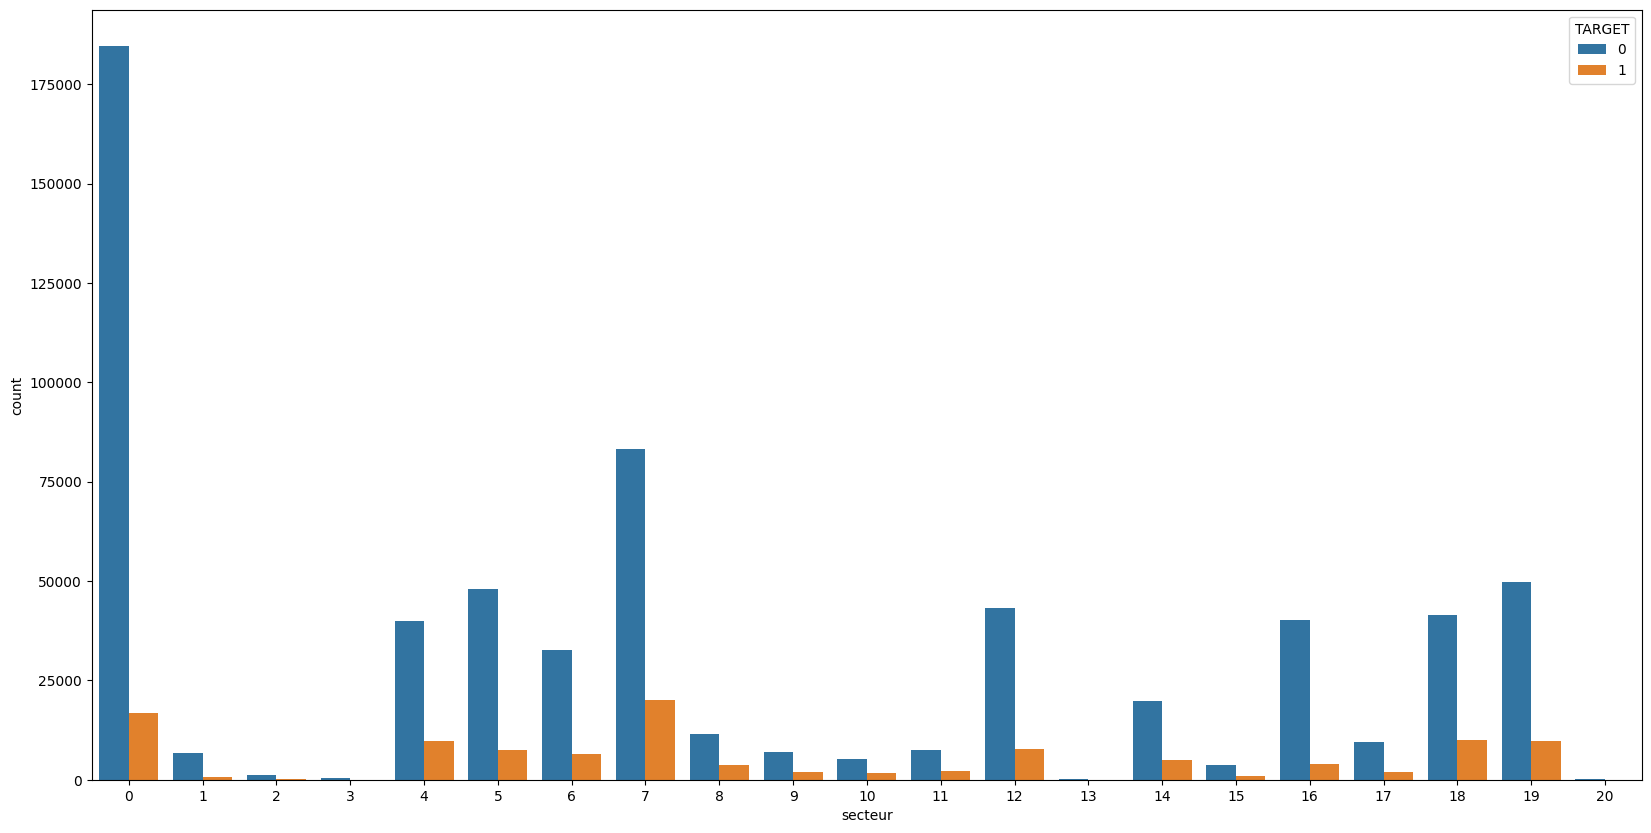

In [28]:
plt.figure(figsize=(20,10))

sns.countplot(data=df_test, x='secteur', hue='TARGET')

plt.show()

## **Analyses secondaires**

In [29]:
# plt.figure()

# sns.scatterplot(df, x='TARGET', y='mois')

# plt.show()

In [30]:
df_test.corr()

/tmp/ipykernel_50522/2476447169.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_test.corr()


,mois,nb_employes,creation,emploi_crees,franchise,emplacement,cred_renouvelable,petit_pret,secteur,TARGET,secure,type_entreprise
mois,1.000000,0.043441,-0.079031,0.026915,0.017812,-0.184765,-0.342549,-0.146582,-0.064533,-0.304129,0.650550,-0.170558
nb_employes,0.043441,1.000000,-0.037683,0.007947,0.004626,-0.040230,-0.033109,-0.026410,-0.032518,-0.021149,0.013811,-0.217075
creation,-0.079031,-0.037683,1.000000,-0.002351,0.133664,0.022503,-0.099157,0.187708,0.049070,0.022287,-0.072080,0.152114
emploi_crees,0.026915,0.007947,-0.002351,1.000000,0.000395,-0.029190,-0.016147,-0.015315,-0.033472,0.016381,-0.007754,-0.023629
franchise,0.017812,0.004626,0.133664,0.000395,1.000000,0.004145,-0.086152,0.026462,0.048676,-0.007612,-0.010636,-0.030613
emplacement,-0.184765,-0.040230,0.022503,-0.029190,0.004145,1.000000,0.309472,-0.098399,0.386597,0.158465,-0.092715,0.117165
cred_renouvelable,-0.342549,-0.033109,-0.099157,-0.016147,-0.086152,0.309472,1.000000,-0.210759,0.142730,0.129789,-0.152954,0.122507
petit_pret,-0.146582,-0.026410,0.187708,-0.015315,0.026462,-0.098399,-0.210759,1.000000,-0.064794,-0.067629,-0.109730,0.126791
secteur,-0.064533,-0.032518,0.049070,-0.033472,0.048676,0.386597,0.142730,-0.064794,1.000000,0.071046,-0.019780,0.104612
TARGET,-0.304129,-0.021149,0.022287,0.016381,-0.007612,0.158465,0.129789,-0.067629,0.071046,1.000000,-0.099174,0.077386


# **Machine Learning**

## **Découpage du dataset**

In [31]:
df

,mois,nb_employes,creation,emploi_crees,franchise,emplacement,cred_renouvelable,petit_pret,montant,secteur,TARGET,secure,type_entreprise
0,84,4,1,0,1,0,N,Y,"$60,000.00",44,0,0,TPE
1,60,2,1,0,1,0,N,Y,"$40,000.00",72,0,0,TPE
2,180,7,0,0,1,0,N,N,"$287,000.00",62,0,0,TPE
3,60,2,0,0,1,0,N,Y,"$35,000.00",0,0,0,TPE
4,240,14,0,7,1,0,N,N,"$229,000.00",0,0,0,PME
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745445,60,6,0,0,1,0,N,N,"$70,000.00",44,0,0,TPE
745446,60,6,0,0,1,0,Y,N,"$85,000.00",44,0,0,TPE
745447,108,26,0,0,1,0,N,N,"$300,000.00",31,0,0,PME
745448,60,6,0,0,1,0,N,Y,"$75,000.00",0,1,0,TPE


In [32]:
def prix (montant):
    montant = montant[1:]
    montant = montant.replace(',', '')
    return float(montant)

In [33]:
df['petit_pret'] = df['petit_pret'].apply(lambda x : 1 if x=='Y' else 0)
df['cred_renouvelable'] = df['cred_renouvelable'].apply(lambda x : 1 if x=='Y' else 0)
df['montant'] = df['montant'].apply(lambda x : prix(x))

In [34]:
X = df.drop(['TARGET'], axis=1)
y = df['TARGET']

In [35]:
X

,mois,nb_employes,creation,emploi_crees,franchise,emplacement,cred_renouvelable,petit_pret,montant,secteur,secure,type_entreprise
0,84,4,1,0,1,0,0,1,60000.0,44,0,TPE
1,60,2,1,0,1,0,0,1,40000.0,72,0,TPE
2,180,7,0,0,1,0,0,0,287000.0,62,0,TPE
3,60,2,0,0,1,0,0,1,35000.0,0,0,TPE
4,240,14,0,7,1,0,0,0,229000.0,0,0,PME
...,...,...,...,...,...,...,...,...,...,...,...,...
745445,60,6,0,0,1,0,0,0,70000.0,44,0,TPE
745446,60,6,0,0,1,0,1,0,85000.0,44,0,TPE
745447,108,26,0,0,1,0,0,0,300000.0,31,0,PME
745448,60,6,0,0,1,0,0,1,75000.0,0,0,TPE


In [36]:
y

0         0
1         0
2         0
3         0
4         0
         ..
745445    0
745446    0
745447    0
745448    1
745449    0
Name: TARGET, Length: 745450, dtype: int64

In [37]:
X['creation'].value_counts()

0    540947
1    204503
Name: creation, dtype: int64

## **Train_set & Test_set**

In [38]:
list_stratify = ['pays', 'petit_pret', 'creation']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.90, random_state=42, stratify=y)
X_train

,mois,nb_employes,creation,emploi_crees,franchise,emplacement,cred_renouvelable,petit_pret,montant,secteur,secure,type_entreprise
94806,60,5,0,2,1,1,0,0,44000.0,56,0,TPE
84202,60,4,1,0,0,1,0,0,12000.0,81,0,TPE
579575,300,12,0,0,1,0,0,0,336000.0,81,1,PME
103080,180,30,0,0,1,0,0,0,250000.0,23,0,PME
491186,240,14,0,0,1,0,0,0,560000.0,0,0,PME
...,...,...,...,...,...,...,...,...,...,...,...,...
510855,24,1,0,1,1,1,1,0,40000.0,56,0,TPE
342155,72,3,0,0,1,0,0,0,50000.0,0,0,TPE
97932,240,7,0,0,1,0,0,0,112000.0,23,0,TPE
122866,84,2,0,0,1,0,0,0,25000.0,0,0,TPE


## **Dummy Modèle**

In [39]:
dummy = DummyClassifier()

In [40]:
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.8524649540545979

## **Création des Transformeurs**

In [41]:
df

,mois,nb_employes,creation,emploi_crees,franchise,emplacement,cred_renouvelable,petit_pret,montant,secteur,TARGET,secure,type_entreprise
0,84,4,1,0,1,0,0,1,60000.0,44,0,0,TPE
1,60,2,1,0,1,0,0,1,40000.0,72,0,0,TPE
2,180,7,0,0,1,0,0,0,287000.0,62,0,0,TPE
3,60,2,0,0,1,0,0,1,35000.0,0,0,0,TPE
4,240,14,0,7,1,0,0,0,229000.0,0,0,0,PME
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745445,60,6,0,0,1,0,0,0,70000.0,44,0,0,TPE
745446,60,6,0,0,1,0,1,0,85000.0,44,0,0,TPE
745447,108,26,0,0,1,0,0,0,300000.0,31,0,0,PME
745448,60,6,0,0,1,0,0,1,75000.0,0,1,0,TPE


In [42]:
cat_var = X.select_dtypes('object').columns
num_var = ["nb_employes", "emploi_crees", "franchise", "emplacement", "montant", "secteur", "mois"]
binaire_var = ["creation", "cred_renouvelable", "petit_pret", "secure"]

cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = RobustScaler()
binaire_transformer = OneHotEncoder()

encoder = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var),
        ('num', num_transformer, num_var),
        ('bin', binaire_transformer, binaire_var)
    ], 
    remainder='passthrough'
)

## **Entraînement du premier modèle**

In [43]:
model = RandomForestClassifier(max_depth=10, class_weight='balanced', random_state=42)
# model = SGDClassifier(class_weight='balanced', random_state=42)

pipe = Pipeline([
    ('enc', encoder),
    ('model', model),
])

model = pipe.fit(X_train, y_train)

prediction = model.predict(X_test)

In [44]:
print(f1_score(y_test, prediction))
print(classification_report(y_test, prediction))

0.6724392971822347
              precision    recall  f1-score   support

           0       0.97      0.88      0.93     63547
           1       0.56      0.85      0.67     10998

    accuracy                           0.88     74545
   macro avg       0.76      0.87      0.80     74545
weighted avg       0.91      0.88      0.89     74545



In [45]:
print(confusion_matrix(y_test, prediction))

[[56147  7400]
 [ 1679  9319]]


In [46]:
model.steps[0][1].get_feature_names_out()

array(['cat__type_entreprise_AUTO', 'cat__type_entreprise_ETI',
       'cat__type_entreprise_GE', 'cat__type_entreprise_PME',
       'cat__type_entreprise_TPE', 'num__nb_employes',
       'num__emploi_crees', 'num__franchise', 'num__emplacement',
       'num__montant', 'num__secteur', 'num__mois', 'bin__creation_0',
       'bin__creation_1', 'bin__cred_renouvelable_0',
       'bin__cred_renouvelable_1', 'bin__petit_pret_0',
       'bin__petit_pret_1', 'bin__secure_0', 'bin__secure_1'],
      dtype=object)

In [47]:
feature_importances = model.named_steps.model.feature_importances_
feature_names = model.steps[0][1].get_feature_names_out()

df_importance = pd.DataFrame(data=feature_importances, columns=['coef'], index=feature_names)

df_importance.sort_values('coef')

,coef
cat__type_entreprise_GE,0.000012
cat__type_entreprise_ETI,0.000074
cat__type_entreprise_AUTO,0.000121
cat__type_entreprise_TPE,0.002322
bin__creation_1,0.003236
cat__type_entreprise_PME,0.003281
bin__creation_0,0.003493
bin__petit_pret_1,0.005349
bin__petit_pret_0,0.005902
bin__secure_0,0.007312


<AxesSubplot: >

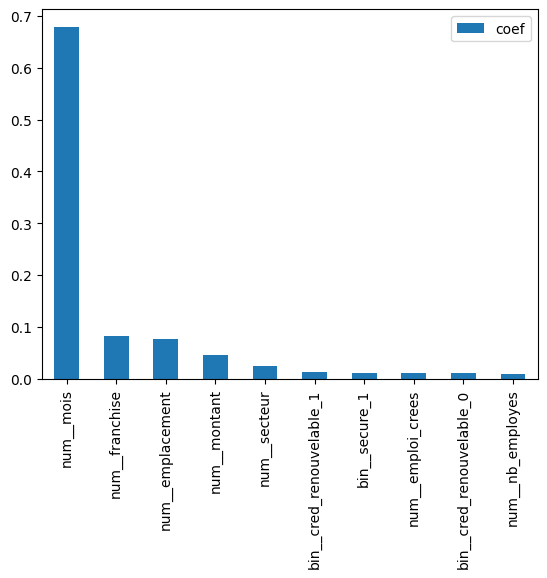

In [48]:
df_importance.sort_values('coef', ascending=False).head(10).plot(kind='bar')

In [49]:
df.to_csv('données/données_finales.csv', index=False)